In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [53]:
# Importing libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.metrics import accuracy_score
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [5]:
train.shape

(1460, 81)

In [6]:
test.shape

(1459, 80)

In [28]:
!pip install DataGuru
import DataGuru as DG

<Axes: >

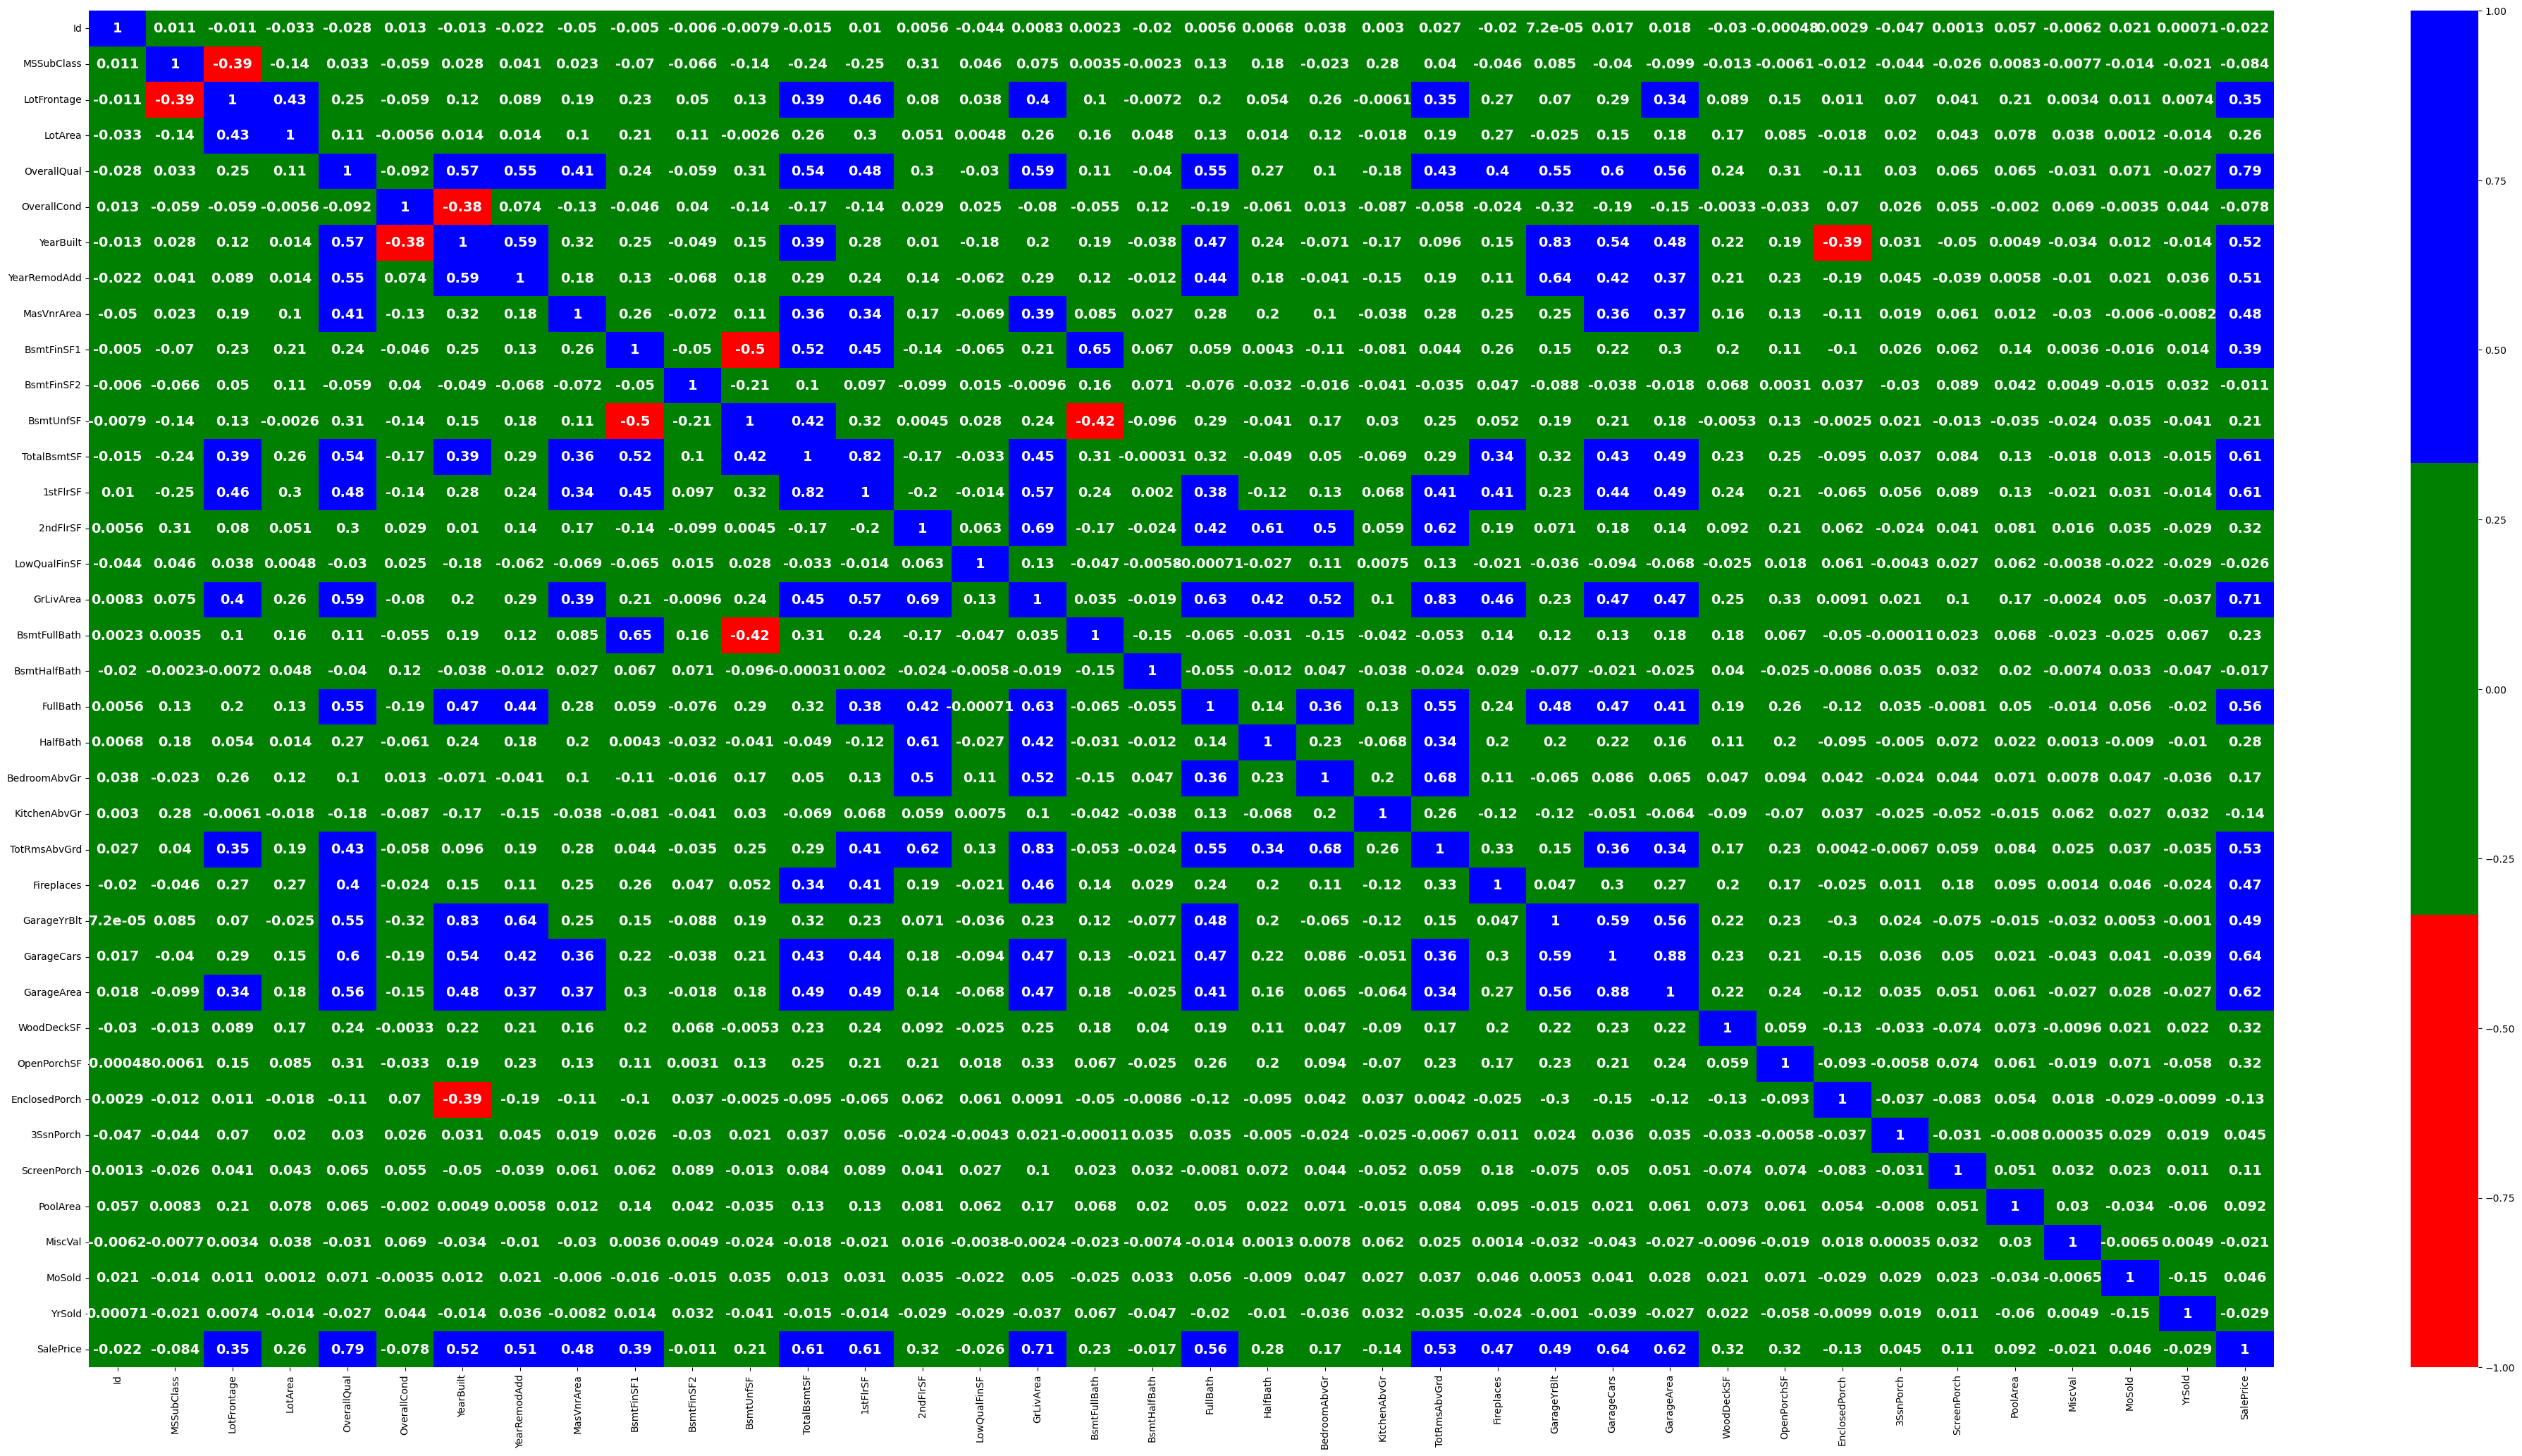

In [14]:
# 상관 관계 분석
corr = train.corr(numeric_only = True)
plt.figure(figsize=(50, 25)) # Make the heatmap larger 
sns.heatmap(corr, cmap = ["red", "green", "blue"], vmin = -1, vmax = 1, annot = True, 
            annot_kws = {'fontsize':14, 'fontweight':'bold'})

In [34]:
# 결측 데이터에 대한 EDA
DG.missingValues(test)

,Total Value,Total Missing Value,Missing Value Rate,Data Type,Unique Value,Total Unique Value
Variable,,,,,,
PoolQC,1459,1456,0.9979,object,"[nan, Ex, Gd]",3
MiscFeature,1459,1408,0.9650,object,"[nan, Gar2, Shed, Othr]",4
Alley,1459,1352,0.9267,object,"[nan, Pave, Grvl]",3
Fence,1459,1169,0.8012,object,"[MnPrv, nan, GdPrv, GdWo, MnWw]",5
FireplaceQu,1459,730,0.5003,object,"[nan, TA, Gd, Po, Fa, Ex]",6
LotFrontage,1459,227,0.1556,float64,"[80.0, 81.0, 74.0, 78.0, 43.0, 75.0, nan, 63.0...",116
GarageCond,1459,78,0.0535,object,"[TA, nan, Fa, Gd, Po, Ex]",6
GarageYrBlt,1459,78,0.0535,float64,"[1961.0, 1958.0, 1997.0, 1998.0, 1992.0, 1993....",98
GarageQual,1459,78,0.0535,object,"[TA, nan, Fa, Gd, Po]",5


In [70]:
# 결측치 처리하는 함수
def handle_missing_values(df):
    # 결측치가 많은 열은 무의미한 결과를 야기할것 같아 열 삭제
    df = df.drop('Alley', axis=1)
    df = df.drop('FireplaceQu', axis=1)
    df = df.drop('PoolQC', axis=1)
    df = df.drop('Fence', axis=1)
    df = df.drop('MiscFeature', axis=1)

    # 결측치 처리 코드
    # NA -> 0으로 대체
    for col in ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond",
               "MasVnrType", "MasVnrArea"]:
        df[col] = df[col].fillna(0)

    # 지하실 크기가 0이거나 NA 인 값은 해당 지하실 관련 행 -> 0으로 대체
    for i in range(df.shape[0]):
        if df.at[i, "BsmtUnfSF"] == 0 or pd.isnull(train.at[i, "BsmtUnfSF"]):
            for col in ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF"]:
                df[col] = 0 

    # NA -> 최빈값으로 대체 
    df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])

    # NA -> mean값으로 대체
    df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)
    
    # 결측값 처리가 안된 소수행 처리
    for col in ["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "Functional", "SaleType", "GarageCars"]:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    return df

In [71]:
# 결측값 처리 함수 적용
train_df = handle_missing_values(train)
test_df = handle_missing_values(test)

In [72]:
# 상관관계 분석 & 도메인 지식 리서치를 통해서 컬럼 선택 -> 훈련 데이터 설정
select_list = ["SalePrice", "MSZoning","LotFrontage","LotArea","Neighborhood","OverallCond","Foundation","HeatingQC","CentralAir","Electrical","1stFlrSF","FullBath","TotRmsAbvGrd","Functional","GarageType","GarageCars","GarageQual","SaleType","SaleCondition"]
select_list_test = ["MSZoning","LotFrontage","LotArea","Neighborhood","OverallCond","Foundation","HeatingQC","CentralAir","Electrical","1stFlrSF","FullBath","TotRmsAbvGrd","Functional","GarageType","GarageCars","GarageQual","SaleType","SaleCondition"]
train_select = train_df[select_list]
test_select = test_df[select_list_test]

train_X = train_select.drop(columns = ["SalePrice"])
train_y = train_select["SalePrice"]
test_X = test_select

In [73]:
# 범주형 데이터 데이터 타입 처리

# str인 column 추출
a = train_X.dtypes
b = test_X.dtypes
object_idx_train = []
object_idx_test = []

for i in range(len(a)):
    if a[i] == 'object':
        object_idx_train.append(i)
for j in range(len(b)):
    if b[j] == 'object':
        object_idx_test.append(j)

object_train = [train_X.columns[x] for x in object_idx_train]
object_test = [test_X.columns[x] for x in object_idx_test]

#위에 결측치 처리에서 na를 0으로 줘서 int랑 str이랑 섞여 있는 문제가 발생, int->str로 바꿔줌
for column in object_train:
    train_X[column] = train_X[column].astype(str)

for column in object_test:
    test_X[column] = test_X[column].astype(str)

In [74]:
# 라벨 변환
from sklearn.preprocessing import LabelEncoder

qual_col = object_train

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_X[i])
    train_X[i] = le.transform(train_X[i])
    test_X[i] = le.transform(test_X[i]) 
    
print(train_X.dtypes)
print(test_X.dtypes)

MSZoning           int64
LotFrontage      float64
LotArea            int64
Neighborhood       int64
OverallCond        int64
Foundation         int64
HeatingQC          int64
CentralAir         int64
Electrical         int64
1stFlrSF           int64
FullBath           int64
TotRmsAbvGrd       int64
Functional         int64
GarageType         int64
GarageCars         int64
GarageQual         int64
SaleType           int64
SaleCondition      int64
dtype: object
MSZoning           int64
LotFrontage      float64
LotArea            int64
Neighborhood       int64
OverallCond        int64
Foundation         int64
HeatingQC          int64
CentralAir         int64
Electrical         int64
1stFlrSF           int64
FullBath           int64
TotRmsAbvGrd       int64
Functional         int64
GarageType         int64
GarageCars       float64
GarageQual         int64
SaleType           int64
SaleCondition      int64
dtype: object


In [76]:
# 데이터 스케일링
scaler = MinMaxScaler()
scaled_train_X = scaler.fit_transform(train_X)
scaled_test_X = scaler.fit_transform(test_X)

In [77]:
# 모델 학습 
rf = RandomForestClassifier()
rf.fit(scaled_train_X, train_y)
y_pred = rf.predict(scaled_test_X)

In [81]:
# 예측값 토대로 제출 데이터 생성
test = test.set_index('Id')
df_submission = pd.DataFrame(data = {'Id': test.index, 'SalePrice': y_pred})
df_submission.head()

,Id,SalePrice
0,1461,135000
1,1462,176000
2,1463,132250
3,1464,145000
4,1465,245500


In [82]:
df_submission.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
